In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from hydra import initialize, compose
from omegaconf import OmegaConf
from icecream import ic

from discovery_result_dataclass import discovery_result
from tigramite import plotting as tp

from pathlib import Path


from causal_discovery_tools import get_link_assumptions

fontsize_title = 18
fontsize_legend = 16
fontsize_ticks = 13

sns.set_style("whitegrid")

# Data loading

In [2]:
runtype = "production"
with initialize(config_path="conf/io", version_base=None):
    conf = compose(config_name=runtype)

# define basin ids
basin_ids = conf['ids']


resampled_files = [file for file in os.listdir(os.path.join(conf['models'], "discovery_resampled")) if file.endswith(".pkl")]
simulated_files = [file for file in os.listdir(os.path.join(conf['models'], "discovery_simulated")) if file.endswith(".pkl")]
observed_files = [file for file in os.listdir(os.path.join(conf['models'], "discovery_observed")) if file.endswith(".pkl")]
resampled_as_observed_files = [file for file in os.listdir(os.path.join(conf['models'], "discovery_resampled_as_observed")) if file.endswith(".pkl")]
resampled_as_simulated_files = [file for file in os.listdir(os.path.join(conf['models'], "discovery_resampled_as_simulated")) if file.endswith(".pkl")]

resampled_results = []
simulated_results = []
observed_results = []
resampled_as_observed_results = []
resampled_as_simulated_results = []

for file in tqdm(resampled_files):
    file_path = os.path.join(conf['models'], "discovery_resampled", file)
    result = discovery_result.load_from_disk(file_path=file_path)
    resampled_results.append(result)

for file in tqdm(simulated_files):
    file_path = os.path.join(conf['models'], "discovery_simulated", file)
    result = discovery_result.load_from_disk(file_path=file_path)
    simulated_results.append(result)

for file in tqdm(observed_files):
    file_path = os.path.join(conf['models'], "discovery_observed", file)
    result = discovery_result.load_from_disk(file_path=file_path)
    observed_results.append(result)

for file in tqdm(resampled_as_observed_files):
    file_path = os.path.join(conf['models'], "discovery_resampled_as_observed", file)
    result = discovery_result.load_from_disk(file_path=file_path)
    resampled_as_observed_results.append(result)

for file in tqdm(resampled_as_simulated_files):
    file_path = os.path.join(conf['models'], "discovery_resampled_as_simulated", file)
    result = discovery_result.load_from_disk(file_path=file_path)
    resampled_as_simulated_results.append(result)




  0%|          | 0/11259 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

# Local helper function definition

## Comparison metrics

### Fraction of uncertain edges

In [3]:
def calculate_number_of_links_in_graph(graph: np.ndarray) -> int:
    """calculates the number of discovered links in a graph discovered by tigramite/pcmci

    Args:
        graph (np.ndarray): graph in the tigramite format

    Returns:
        int: number of links in that graph
    """
    # remove above diagonal links to avoid double-counting
    graph_adjusted = set_above_diagonal_to_empty(graph)
    number_of_links = np.sum(graph != "")
    return number_of_links


def set_above_diagonal_to_empty(graph: np.ndarray) -> np.ndarray:
    """for a tigramite result graphs, sets all elements above the diagonal line for tau = 0 to empty string to avoid double counting when comparing to other graphs

    Args:
        graph (np.ndarray): tigramit result graph

    Returns:
        np.ndarray: tigramite result graphs with empty strings above the diagonal line
    """
    fixed_graph = graph
    t = 0
    graph_slice = graph[:, :, t]
    rows, columns = graph_slice.shape
    for row in range(rows):
        for column in range(row + 1, columns):
            graph_slice[row, column] = ""
    fixed_graph[:, :, t] = graph_slice
    return fixed_graph



def comparison_matrix_graph(graph1: np.ndarray, graph2: np.ndarray) -> np.ndarray:
    """comparison matrix between two tigramite result graphs. Elements are False if link is the same, True if different.
    to calculate distance between graphs, elements above the diagonal should be regarded to not count links twice

    Args:
        graph1 (np.ndarray): tigramite result graph
        graph2 (np.ndarray): tigramite result graph

    Returns:
        np.ndarray: False if links are the same, True if not. Same shape as imput graph.
    """
    matrix = graph1 != graph2
    return matrix


def distance_between_graphs(
    graph1: np.ndarray, graph2: np.ndarray, normalize: bool = False
):
    """calculates the distance between two graphs by the number of links that are not the same

    Args:
        graph1 (np.ndarray): tigramite result graph
        graph2 (np.ndarray): tigramite result graph
        normalize (bool): if the distance should be normalized my the mean number of links in the two graphs

    Returns:
        float: distance between graphs as number of links not equal
    """
    # first set all elements above the diagonal line to empty string to avoid double counting
    graph1 = set_above_diagonal_to_empty(graph1)
    graph2 = set_above_diagonal_to_empty(graph2)
    # get comparison matrix
    matrix = comparison_matrix_graph(graph1, graph2)
    # distance are the number of links  that are not equal between the two graphs
    distance = np.sum(matrix)
    # normalize by the mean number of links of the two graphs
    if normalize:
        number_of_links1 = np.sum(graph1 != "")
        number_of_links2 = np.sum(graph2 != "")
        average_number_of_links = (number_of_links1 + number_of_links2) / 2
        distance = distance / average_number_of_links
    return distance


def graph_distance_distribution_between_model_list(
    models: list, normalize=False
) -> list:
    """calculates the (normalized) distance between graphs of all models

    Args:
        models (list):  list of tigramite result graphs
        normalize (bool, optional): if the distance should be normalized my the mean number of links in the two graphs. Defaults to False.

    Returns:
        list: list of distances between all graphs
    """
    distances = []
    graphs = [m.results["graph"] for m in models]
    for i, graph1 in enumerate(graphs):
        for graph2 in graphs[i + 1 :]:
            distance = distance_between_graphs(graph1, graph2, normalize=normalize)
            distances.append(distance)
    return distances

### F1 Score

In [4]:
def true_positives(y_true, y_pred, maximum_discoverable):
    """
    Compute true positives (TP) for graph comparison, considering only edges permitted by maximum_discoverable.

    TP: number of edges in both graphs with the same directionality, and permitted by maximum_discoverable.

    Parameters:
    y_true (3D numpy array of strings): ground truth graph
    y_pred (3D numpy array of strings): predicted graph
    maximum_discoverable (3D numpy array of ints): 1 indicates the edge should be counted, 0 otherwise

    Returns:
    int: number of true positives
    """
    tp = 0
    for i in range(y_true.shape[0]):
        for j in range(y_true.shape[1]):
            for k in range(y_true.shape[2]):
                if maximum_discoverable[i, j, k] == 1 and y_true[i, j, k] != '' and y_pred[i, j, k] != '' and y_true[i, j, k] == y_pred[i, j, k]:
                    tp += 1
    return tp

def false_positives(y_true, y_pred, maximum_discoverable):
    """
    Compute false positives (FP) for graph comparison, considering only edges permitted by maximum_discoverable.

    FP: number of edges in predicted graph but not in ground truth graph, and permitted by maximum_discoverable.

    Parameters:
    y_true (3D numpy array of strings): ground truth graph
    y_pred (3D numpy array of strings): predicted graph
    maximum_discoverable (3D numpy array of ints): 1 indicates the edge should be counted, 0 otherwise

    Returns:
    int: number of false positives
    """
    fp = 0
    for i in range(y_true.shape[0]):
        for j in range(y_true.shape[1]):
            for k in range(y_true.shape[2]):
                if maximum_discoverable[i, j, k] == 1 and y_true[i, j, k] == '' and y_pred[i, j, k] != '':
                    fp += 1
    return fp

def true_negatives(y_true, y_pred, maximum_discoverable):
    """
    Compute true negatives (TN) for graph comparison, considering only edges permitted by maximum_discoverable.

    TN: number of non-edges in both graphs, and permitted by maximum_discoverable.

    Parameters:
    y_true (3D numpy array of strings): ground truth graph
    y_pred (3D numpy array of strings): predicted graph
    maximum_discoverable (3D numpy array of ints): 1 indicates the edge should be counted, 0 otherwise

    Returns:
    int: number of true negatives
    """
    tn = 0
    for i in range(y_true.shape[0]):
        for j in range(y_true.shape[1]):
            for k in range(y_true.shape[2]):
                if maximum_discoverable[i, j, k] == 1 and y_true[i, j, k] == '' and y_pred[i, j, k] == '':
                    tn += 1
    return tn

def false_negatives(y_true, y_pred, maximum_discoverable):
    """
    Compute false negatives (FN) for graph comparison, considering only edges permitted by maximum_discoverable.

    FN: number of edges in ground truth graph but not in predicted graph, and permitted by maximum_discoverable.

    Parameters:
    y_true (3D numpy array of strings): ground truth graph
    y_pred (3D numpy array of strings): predicted graph
    maximum_discoverable (3D numpy array of ints): 1 indicates the edge should be counted, 0 otherwise

    Returns:
    int: number of false negatives
    """
    fn = 0
    for i in range(y_true.shape[0]):
        for j in range(y_true.shape[1]):
            for k in range(y_true.shape[2]):
                if maximum_discoverable[i, j, k] == 1 and y_true[i, j, k] != '' and y_pred[i, j, k] == '':
                    fn += 1
    return fn

def precision(y_true, y_pred, maximum_discoverable):
    """
    Compute precision for graph comparison, considering only edges permitted by maximum_discoverable.

    Precision = TP / (TP + FP)

    Parameters:
    y_true (3D numpy array of strings): ground truth graph
    y_pred (3D numpy array of strings): predicted graph
    maximum_discoverable (3D numpy array of ints): 1 indicates the edge should be counted, 0 otherwise

    Returns:
    float: precision
    """
    tp = true_positives(y_true, y_pred, maximum_discoverable)
    fp = false_positives(y_true, y_pred, maximum_discoverable)
    return tp / (tp + fp) if tp + fp > 0 else 0.0

def recall(y_true, y_pred, maximum_discoverable):
    """
    Compute recall for graph comparison, considering only edges permitted by maximum_discoverable.

    Recall = TP / (TP + FN)

    Parameters:
    y_true (3D numpy array of strings): ground truth graph
    y_pred (3D numpy array of strings): predicted graph
    maximum_discoverable (3D numpy array of ints): 1 indicates the edge should be counted, 0 otherwise

    Returns:
    float: recall
    """
    tp = true_positives(y_true, y_pred, maximum_discoverable)
    fn = false_negatives(y_true, y_pred, maximum_discoverable)
    return tp / (tp + fn) if tp + fn > 0 else 0.0

def f1_score(y_true, y_pred, maximum_discoverable):
    """
    Compute F1 score for graph comparison, considering only edges permitted by maximum_discoverable.

    F1 = 2 * (Precision * Recall) / (Precision + Recall)

    Parameters:
    y_true (3D numpy array of strings): ground truth graph
    y_pred (3D numpy array of strings): predicted graph
    maximum_discoverable (3D numpy array of ints): 1 indicates the edge should be counted, 0 otherwise

    Returns:
    float: F1 score
    """
    y_true = set_above_diagonal_to_empty(y_true)
    y_pred = set_above_diagonal_to_empty(y_pred)
    p = precision(y_true, y_pred, maximum_discoverable)
    r = recall(y_true, y_pred, maximum_discoverable)
    return 2 * (p * r) / (p + r) if p + r > 0 else 0.0

def link_assumtion_dict_to_matrix(val_dict, tau_max, n_vars, default=0):
        """Helper function to convert dictionary to matrix format.

        Parameters
        ---------
        val_dict : dict
            Dictionary of form {0:{(0, -1):str, ...}, 1:{...}, ...}.
        tau_max : int
            Maximum lag.
        n_vars : int
            Number of variables.
        default : int
            Default value for entries not part of val_dict.

        Returns
        -------
        matrix : array of shape (N, N, tau_max+1)
            Matrix format of p-values and test statistic values.
        """
        matrix = np.ones((n_vars, n_vars, tau_max + 1))
        matrix *= default

        for j in val_dict.keys():
            for link in val_dict[j].keys():
                k, tau = link
                if tau == 0:
                    matrix[k, j, 0] = matrix[j, k, 0] = 1
                else:
                    matrix[k, j, abs(tau)] = 1
        return matrix


def set_above_diagonal_to_zero(graph: np.ndarray) -> np.ndarray:
    fixed_graph = graph
    t = 0
    graph_slice = graph[:, :, t]
    rows, columns = graph_slice.shape
    for row in range(rows):
        for column in range(row + 1, columns):
            graph_slice[row, column] = 0
    fixed_graph[:, :, t] = graph_slice
    return fixed_graph


#### Example of using the F1 score

In [5]:
test_id = 6123350
testing_results = [m for m in resampled_results if m.basin_id == test_id and m.cond_ind_test == 'GPDC' and m.peaks_used == True and m.sample_size == 1000]
y_true = testing_results[3].discovery_result['graph']
y_pred = testing_results[0].discovery_result['graph']

link_assumptions = get_link_assumptions()

maximum_discoverable_graph_mask = set_above_diagonal_to_zero(link_assumtion_dict_to_matrix(link_assumptions, 7, 5))


ic(true_negatives(y_true, y_pred,maximum_discoverable= maximum_discoverable_graph_mask))
ic(true_positives(y_true, y_pred,maximum_discoverable= maximum_discoverable_graph_mask))
ic(false_negatives(y_true, y_pred,maximum_discoverable= maximum_discoverable_graph_mask))
ic(false_positives(y_true, y_pred,maximum_discoverable= maximum_discoverable_graph_mask))
ic(f1_score(y_true, y_pred,maximum_discoverable= maximum_discoverable_graph_mask))


ic| true_negatives(y_true, y_pred,maximum_discoverable= maximum_discoverable_graph_mask): 5
ic| true_positives(y_true, y_pred,maximum_discoverable= maximum_discoverable_graph_mask): 11
ic| false_negatives(y_true, y_pred,maximum_discoverable= maximum_discoverable_graph_mask): 3
ic| false_positives(y_true, y_pred,maximum_discoverable= maximum_discoverable_graph_mask): 2
ic| f1_score(y_true, y_pred,maximum_discoverable= maximum_discoverable_graph_mask): 0.8148148148148148


0.8148148148148148

# Stability across different sample sizes

## Compute distances

In [6]:
# compute the distances between all samples that should be the same and store them in a long table
dtypes = {
    "basin_id": "int32",
    "sample_size": "int32",
    "fold_id": "int32",
    "cond_ind_test": "str",
    "peaks_used": "bool",
    "discovery_runtime": "float",
    "number_of_links": "int32",
    "number_of_uncertain_links": "float",
    "fraction_of_uncertain_links": "float",
    "f1_score":"float"
}
long_comparison_results = pd.DataFrame(
    {col: pd.Series(dtype=typ) for col, typ in dtypes.items()}
)

# make the masking for the calculation of the f1 score
link_assumptions = get_link_assumptions()
maximum_discoverable_graph_mask = set_above_diagonal_to_zero(link_assumtion_dict_to_matrix(link_assumptions, 7, 5))


for model_index, model in tqdm(enumerate(resampled_results)):
    # calculate the number of links in graph
    number_of_links = calculate_number_of_links_in_graph(
        model.discovery_result["graph"]
    )
    # find models with same basin_id, sample_size, cond_ind_test, and peaks_used to compare the result to
    comparison_models = [
        m
        for m in resampled_results
        if m.basin_id == model.basin_id
        and m.sample_size == model.sample_size
        and m.cond_ind_test == model.cond_ind_test
        and m.peaks_used == model.peaks_used
    ]
    # calculate the number of links that are different to each model in the set of comparison models
    number_of_different_links_to_comparison_models = []
    f1_scores_list = []
    for comparison_model in comparison_models:
        distance = distance_between_graphs(
            model.discovery_result["graph"],
            comparison_model.discovery_result["graph"],
            normalize=False,
        )
        f1 = f1_score(
            comparison_model.discovery_result["graph"],
            model.discovery_result["graph"],
            maximum_discoverable_graph_mask,
        )
        number_of_different_links_to_comparison_models.append(distance)
        f1_scores_list.append(f1)
    mean_number_of_different_links_to_comparison_models = np.mean(
        number_of_different_links_to_comparison_models
    )
    mean_f1_socre = np.mean(f1_scores_list)
    # write the results to the comparison list

    long_comparison_results.loc[model_index, "basin_id"] = int(model.basin_id)
    long_comparison_results.loc[model_index, "sample_size"] = int(model.sample_size)
    long_comparison_results.loc[model_index, "fold_id"] = int(model.fold_id)
    long_comparison_results.loc[model_index, "cond_ind_test"] = model.cond_ind_test
    long_comparison_results.loc[model_index, "peaks_used"] = bool(model.peaks_used)
    long_comparison_results.loc[model_index, "discovery_runtime"] = float(
        model.discovery_runtime
    )
    long_comparison_results.loc[model_index, "number_of_uncertain_links"] = float(
        mean_number_of_different_links_to_comparison_models
    )
    long_comparison_results.loc[model_index, "number_of_links"] = int(
        number_of_links
    )
    # calculate fraction of links by dividing by number of links for selected model
    long_comparison_results["fraction_of_uncertain_links"] = (
    long_comparison_results["number_of_uncertain_links"]
    / long_comparison_results["number_of_links"]
    )
    long_comparison_results.loc[model_index, "f1_score"] = float(mean_f1_socre)

    

0it [00:00, ?it/s]

### GPDC: plotting stability

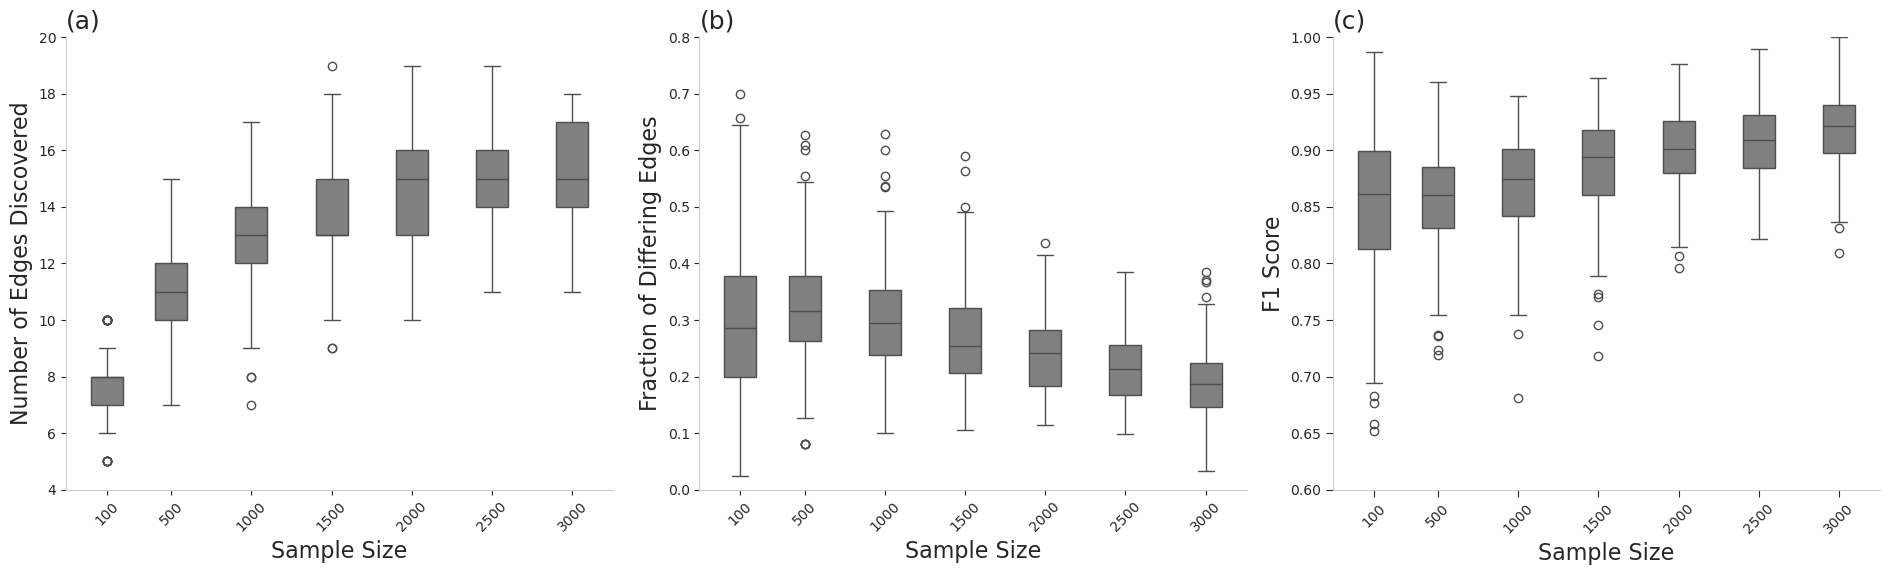

In [7]:
sns.set_style("whitegrid")
example_results = long_comparison_results.loc[long_comparison_results['cond_ind_test'] == 'GPDC']
example_results = example_results.loc[example_results['sample_size'] != 200]
no_peak = example_results.loc[example_results['peaks_used'] == False]
peak = example_results.loc[example_results['peaks_used'] == True]
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(19, 6))
fig.suptitle(f'', fontsize=16)
# plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.rcParams['xtick.labelsize'] = fontsize_ticks
plt.rcParams['ytick.labelsize'] = fontsize_ticks
plt.tick_params(axis='both', which='both', length=5)



sns.boxplot(data=peak, x='sample_size', y='number_of_links', ax=ax[0], native_scale=True, width=0.5, color='gray')

# ax[0].set_ylim(0, 20)


ax[0].set_xlabel('Sample Size', fontsize=fontsize_legend)
ax[0].set_ylabel('Number of Edges Discovered', fontsize=fontsize_legend)
ax[0].grid(False)
ax[0].set_title('(a)',fontsize=fontsize_title,loc='left')
ax[0].tick_params(left=True, bottom=True)
ax[0].set_xticks([100,500,1000,1500,2000,2500,3000],labels = [100,500,1000,1500,2000,2500,3000],  rotation  = 45)
# ax[0].set_xticklabels([100,500,1000,1500,2000,2500,3000])
ax[0].set_ylim(4,20)

sns.boxplot(data=peak, x='sample_size', y='fraction_of_uncertain_links', ax=ax[1], native_scale=True, width=0.5, color='gray')


ax[1].set_xlabel('Sample Size', fontsize=fontsize_legend)
ax[1].set_ylabel('Fraction of Differing Edges', fontsize=fontsize_legend)
ax[1].grid(False)
ax[1].set_title(F"(b)",fontsize=fontsize_title,loc='left')
ax[1].tick_params(left=True, bottom=True)
ax[1].set_xticks([100,500,1000,1500,2000,2500,3000],labels = [100,500,1000,1500,2000,2500,3000],  rotation  = 45)
ax[1].set_ylim(0,0.8)

sns.boxplot(data=peak, x='sample_size', y='f1_score', ax=ax[2], native_scale=True, width=0.5, color='gray')
# ax.set_title('Peak')

# sns.boxplot(data=no_peak, x='sample_size', y='number_of_links', ax=axes[1], native_scale=True, width=0.5)
# axes[1].set_title('Random')

ax[2].set_ylim(0.6, 1)

ax[2].set_xlabel('Sample Size', fontsize=fontsize_legend)
ax[2].set_ylabel('F1 Score', fontsize=fontsize_legend)
ax[2].grid(False)
ax[2].set_title("(c)",fontsize=fontsize_title,loc='left')
ax[2].tick_params(left=True, bottom=True)
ax[2].set_xticks([100,500,1000,1500,2000,2500,3000],labels = [100,500,1000,1500,2000,2500,3000],  rotation  = 45)

# Remove the top and right borders of the plot
sns.despine()
plt.tight_layout()
plt.savefig('paper_plots/all_basin_stability_boxplots.pdf', format = 'pdf')


## ParCorr plotting stability

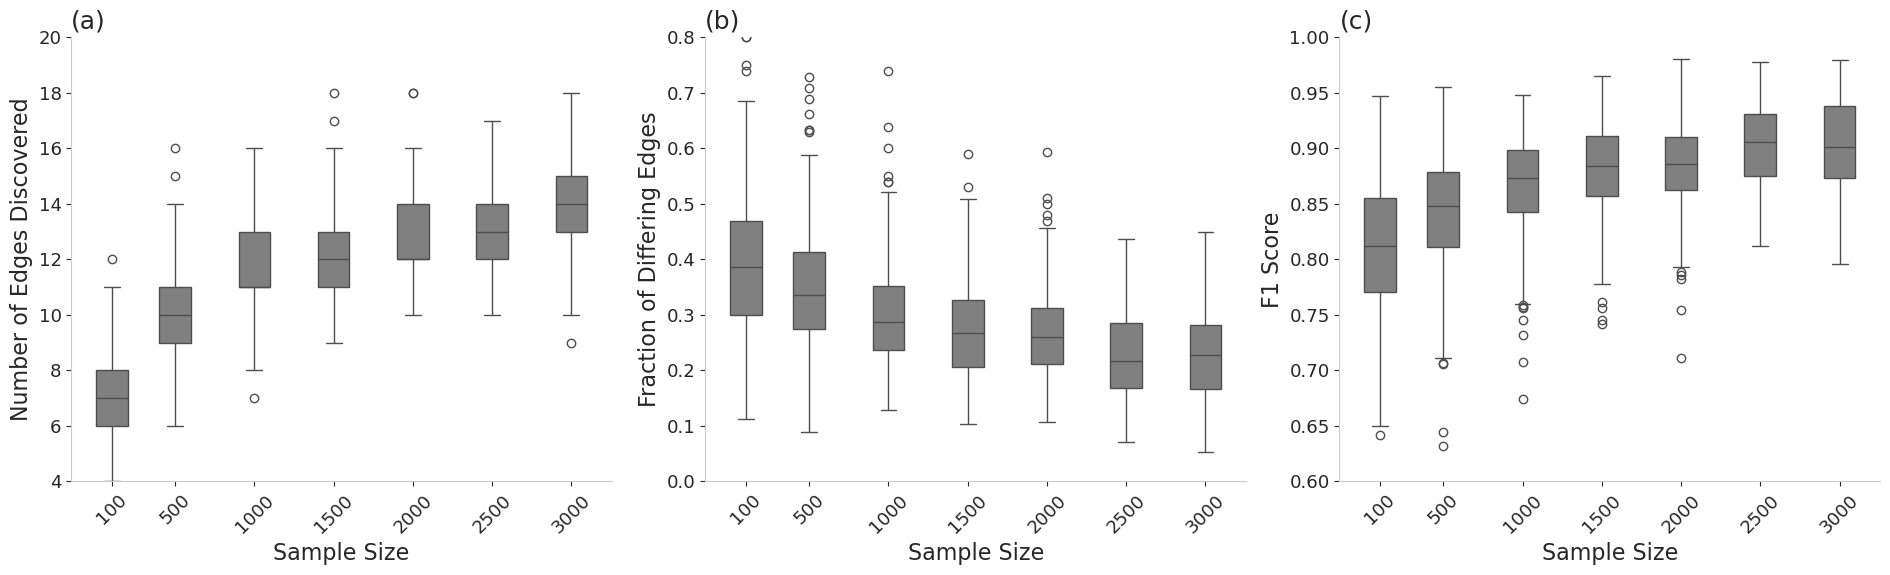

In [8]:
sns.set_style("whitegrid")
example_results = long_comparison_results.loc[long_comparison_results['cond_ind_test'] == 'ParCorr']
example_results = example_results.loc[example_results['sample_size'] != 200]
no_peak = example_results.loc[example_results['peaks_used'] == False]
peak = example_results.loc[example_results['peaks_used'] == True]
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(19, 6))
fig.suptitle(f'', fontsize=16)
# plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.rcParams['xtick.labelsize'] = fontsize_ticks
plt.rcParams['ytick.labelsize'] = fontsize_ticks



sns.boxplot(data=peak, x='sample_size', y='number_of_links', ax=ax[0], native_scale=True, width=0.5, color='gray')

# ax[0].set_ylim(0, 20)


ax[0].set_xlabel('Sample Size', fontsize=fontsize_legend)
ax[0].set_ylabel('Number of Edges Discovered', fontsize=fontsize_legend)
ax[0].grid(False)
ax[0].set_title('(a)',fontsize=fontsize_title,loc='left')
ax[0].tick_params(left=True, bottom=True)
ax[0].set_xticks([100,500,1000,1500,2000,2500,3000],labels = [100,500,1000,1500,2000,2500,3000],  rotation  = 45)
ax[0].set_ylim(4,20)
# ax[0].set_xticklabels([100,500,1000,1500,2000,2500,3000])

sns.boxplot(data=peak, x='sample_size', y='fraction_of_uncertain_links', ax=ax[1], native_scale=True, width=0.5, color='gray')


ax[1].set_xlabel('Sample Size', fontsize=fontsize_legend)
ax[1].set_ylabel('Fraction of Differing Edges', fontsize=fontsize_legend)
ax[1].grid(False)
ax[1].set_title(F"(b)",fontsize=fontsize_title,loc='left')
ax[1].tick_params(left=True, bottom=True)
ax[1].set_xticks([100,500,1000,1500,2000,2500,3000],labels = [100,500,1000,1500,2000,2500,3000],  rotation  = 45)
ax[1].set_ylim(0,0.8)
sns.boxplot(data=peak, x='sample_size', y='f1_score', ax=ax[2], native_scale=True, width=0.5, color='gray')
# ax.set_title('Peak')

# sns.boxplot(data=no_peak, x='sample_size', y='number_of_links', ax=axes[1], native_scale=True, width=0.5)
# axes[1].set_title('Random')

ax[2].set_ylim(0.6, 1)

ax[2].set_xlabel('Sample Size', fontsize=fontsize_legend)
ax[2].set_ylabel('F1 Score', fontsize=fontsize_legend)
ax[2].grid(False)
ax[2].set_title("(c)",fontsize=fontsize_title,loc='left')
ax[2].tick_params(left=True, bottom=True)
ax[2].set_xticks([100,500,1000,1500,2000,2500,3000],labels = [100,500,1000,1500,2000,2500,3000],  rotation  = 45)

# Remove the top and right borders of the plot
sns.despine()
plt.tight_layout()

plt.savefig('paper_plots/all_basin_stability_boxplots_parcorr.pdf', format = 'pdf')


# Comparison to observed/simulated and resampled graphs

## GPDC

### calculating distances

In [10]:
ids =  [
    6337610,
    6502171,
    6335046,
    6338200,
    6338160,
    6123710,
    6503851,
    6229100,
    6335351,
    6123350,
    6139682,
    6503280,
    6503500,
    6731600,
    6338120,
    6934571,
    6338161,
    6503855,
    6335160,
    6139790,
    6502151,
    6233350,
    6233100,
    6321100,
    6342521,
    6604220,
    6243400,
    6338150,
    6503281,
    6337504,
    6335045,
    6503201,
    6335081,
    6119200,
    6854590,
    6337050,
    6503180,
    6123160,
    6503351,
    6335360,
    6503301,
    6855409,
    6136200,
    6503300,
    6233520,
  ]
ic(len(ids))

ic| len(ids): 45


45

In [11]:
obs_distance_distribution = {}
res_as_obs_distance_distribution = {}
res_as_sim_distance_distribution = {}
sim_distance_distribution = {}
obs_f1_distribution = {}
res_as_obs_f1_distribution = {}
res_as_sim_f1_distribution = {}
sim_f1_distribution = {}

# make the masking for the calculation of the f1 score
link_assumptions = get_link_assumptions()
maximum_discoverable_graph_mask = set_above_diagonal_to_zero(link_assumtion_dict_to_matrix(link_assumptions, 7, 5))

ic(len(ids))
for id in  ids:
    print(id)
    obs_model = [m for m in observed_results if m.basin_id == id and m.cond_ind_test == 'GPDC' and m.peaks_used == True][0]
    res_as_obs_models = [m for m in resampled_as_observed_results if m.basin_id == id and m.cond_ind_test == 'GPDC' and m.peaks_used == True]
    sim_model = [m for m in simulated_results if m.basin_id == id and m.cond_ind_test == 'GPDC' and m.peaks_used == True][0]
    res_as_sim_models = [m for m in resampled_as_simulated_results if m.basin_id == id and m.cond_ind_test == 'GPDC' and m.peaks_used == True]

    res_as_obs_distances = []
    res_as_obs_f1 = []
    res_as_sim_distances = []
    res_as_sim_f1 = []
    for i in range(len(res_as_obs_models) -1):
        model_as_obs = res_as_obs_models[i]
        comparison_models_as_obs = res_as_obs_models[i+1:]
        for j in range(len(comparison_models_as_obs)):
            comp_model_as_obs = comparison_models_as_obs[j]
            # compare obs models
            distance = distance_between_graphs(model_as_obs.discovery_result['graph'], comp_model_as_obs.discovery_result['graph'])
            res_as_obs_distances.append(distance)
            f1 = f1_score(comp_model_as_obs.discovery_result['graph'],model_as_obs.discovery_result['graph'],maximum_discoverable_graph_mask  )
            res_as_obs_f1.append(f1)

    for i in range(len(res_as_sim_models) -1):
        model_as_sim = res_as_sim_models[i]
        comparison_models_as_sim = res_as_sim_models[i+1:]
        for j in range(len(comparison_models_as_sim)):
            comp_model_as_sim = comparison_models_as_sim[j]
            # compare sim models
            distance = distance_between_graphs(model_as_sim.discovery_result['graph'], comp_model_as_sim.discovery_result['graph'])
            res_as_sim_distances.append(distance)
            f1 = f1_score(comp_model_as_sim.discovery_result['graph'],model_as_sim.discovery_result['graph'],maximum_discoverable_graph_mask  )
            res_as_sim_f1.append(f1)

    obs_distances = []
    obs_f1 = []
    sim_distances = []
    sim_f1 = []
    for j in range(len(res_as_obs_models)):
        comp_model_as_obs = res_as_obs_models[j]
        # compare to observation
        distance = distance_between_graphs(obs_model.discovery_result['graph'], comp_model_as_obs.discovery_result['graph'])
        obs_distances.append(distance)
        f1 = f1_score(comp_model_as_obs.discovery_result['graph'],obs_model.discovery_result['graph'],maximum_discoverable_graph_mask  )
        obs_f1.append(f1)
    

    for j in range(len(res_as_sim_models)):
        comp_model_as_sim = res_as_sim_models[j]
        # compare to simulation
        distance = distance_between_graphs(sim_model.discovery_result['graph'], comp_model_as_sim.discovery_result['graph'])
        sim_distances.append(distance)
        f1 = f1_score(comp_model_as_sim.discovery_result['graph'],sim_model.discovery_result['graph'],maximum_discoverable_graph_mask  )
        sim_f1.append(f1)

        

    obs_distance_distribution[id] = obs_distances
    res_as_obs_distance_distribution[id] = res_as_obs_distances
    obs_f1_distribution[id] = obs_f1
    res_as_obs_f1_distribution[id] = res_as_obs_f1

    sim_distance_distribution[id] = sim_distances
    res_as_sim_distance_distribution[id] = res_as_sim_distances
    sim_f1_distribution[id] = sim_f1
    res_as_sim_f1_distribution[id] = res_as_sim_f1

ic(len(ids))


ic| len(ids): 45


6337610
6502171
6335046
6338200
6338160
6123710
6503851
6229100
6335351
6123350
6139682
6503280
6503500
6731600
6338120
6934571
6338161
6503855
6335160
6139790
6502151
6233350
6233100
6321100
6342521
6604220
6243400
6338150
6503281
6337504
6335045
6503201
6335081
6119200
6854590
6337050
6503180
6123160
6503351
6335360
6503301
6855409
6136200
6503300
6233520


ic| len(ids): 45


45

### performing significance tests

In [12]:
from scipy import stats
from scipy.stats import false_discovery_control
stat_test_results = pd.DataFrame(np.nan, index=ids, columns=['dist_obs','dist_sim','f1_obs','f1_sim'])
for id in ids:
    # Perform independent t-test (Welch’s t-test)
    t_statistic, p_value = stats.ttest_ind(obs_distance_distribution[id], res_as_obs_distance_distribution[id], equal_var=False)
    stat_test_results.at[id, 'dist_obs'] = p_value

    t_statistic, p_value = stats.ttest_ind(sim_distance_distribution[id], res_as_sim_distance_distribution[id], equal_var=False)
    stat_test_results.at[id, 'dist_sim'] = p_value

    t_statistic, p_value = stats.ttest_ind(obs_f1_distribution[id], res_as_obs_f1_distribution[id], equal_var=False)
    stat_test_results.at[id, 'f1_obs'] = p_value

    t_statistic, p_value = stats.ttest_ind(sim_f1_distribution[id], res_as_sim_f1_distribution[id], equal_var=False)
    stat_test_results.at[id, 'f1_sim'] = p_value


# Benjamin Hochberg correction for multiple testing
stat_test_results_adjusted = stat_test_results
stat_test_results_adjusted.iloc[:,:] = false_discovery_control(stat_test_results, axis = 0, method = 'bh')

stat_test_results_adjusted


,dist_obs,dist_sim,f1_obs,f1_sim
6337610,7.196536e-05,0.046358,1.799888e-04,0.184980
6502171,6.152472e-07,0.021610,9.405241e-07,0.184980
6335046,7.369968e-06,0.759547,5.472302e-04,0.745293
6338200,7.656637e-08,0.000110,3.708960e-07,0.000181
6338160,1.389423e-03,0.000270,4.879311e-04,0.000851
6123710,5.277005e-05,0.315576,9.761676e-06,0.960506
6503851,3.524394e-05,0.982092,9.422494e-05,0.846505
6229100,9.383402e-11,0.913603,1.240497e-10,0.993047
6335351,2.508751e-08,0.759547,2.070263e-07,0.378241
6123350,1.130254e-03,0.000027,2.920134e-03,0.026043


In [13]:
alpha = 0.05
filtered_ids_per_column = {}

for col in stat_test_results.columns:
    filtered_ids = stat_test_results[stat_test_results[col] < alpha].index
    filtered_ids_per_column[col] = filtered_ids


for col, f_ids in filtered_ids_per_column.items():
    print(f"{len(f_ids)} IDs for {col} where values < {alpha}: {list(f_ids)}. That's {len(f_ids)} basins")
ic(len(ids))

ic| len(ids): 45


39 IDs for dist_obs where values < 0.05: [6337610, 6502171, 6335046, 6338200, 6338160, 6123710, 6503851, 6229100, 6335351, 6123350, 6139682, 6503280, 6503500, 6731600, 6338120, 6934571, 6338161, 6503855, 6335160, 6502151, 6233350, 6321100, 6342521, 6604220, 6243400, 6337504, 6335045, 6503201, 6335081, 6119200, 6337050, 6503180, 6123160, 6503351, 6335360, 6855409, 6136200, 6503300, 6233520]. That's 39 basins
18 IDs for dist_sim where values < 0.05: [6337610, 6502171, 6338200, 6338160, 6123350, 6338120, 6338161, 6335160, 6321100, 6342521, 6243400, 6503281, 6337504, 6335045, 6503201, 6119200, 6503301, 6503300]. That's 18 basins
38 IDs for f1_obs where values < 0.05: [6337610, 6502171, 6335046, 6338200, 6338160, 6123710, 6503851, 6229100, 6335351, 6123350, 6503280, 6503500, 6731600, 6338120, 6934571, 6338161, 6503855, 6335160, 6502151, 6233350, 6321100, 6342521, 6604220, 6243400, 6337504, 6335045, 6503201, 6335081, 6119200, 6854590, 6337050, 6503180, 6123160, 6503351, 6335360, 6855409, 613

45

In [14]:
# Benjamin Hochberg correction for multiple testing
alpha = 0.05



p_adjusted_obs = false_discovery_control(stat_test_results['dist_obs'], axis = 0, method = 'bh')
p_adjusted_sim = false_discovery_control(stat_test_results['dist_sim'], axis = 0, method = 'bh')
p_smaller_alpha_obs = len([p for p in p_adjusted_obs if p < alpha])
p_smaller_alpha_sim = len([p for p in p_adjusted_sim if p < alpha])

### plotting histograms

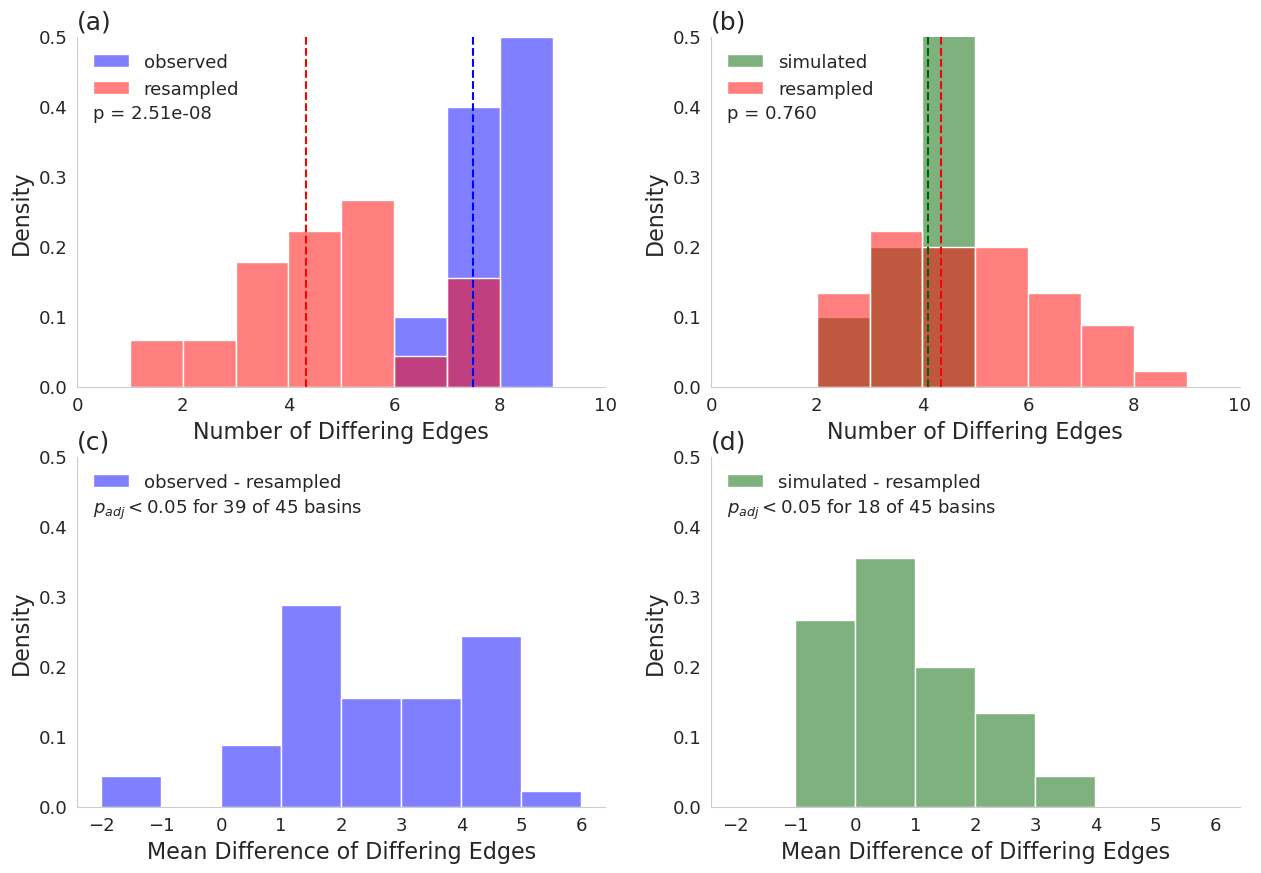

In [15]:
import statistics
alpha = 0.05
plt.rcParams['xtick.labelsize'] = fontsize_ticks
plt.rcParams['ytick.labelsize'] = fontsize_ticks
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
# selected_basin_ids = [
#                     6335351,
#                     6731600,
#                     6503281
#                     ]
example_id = 6335351

def mean(values:list) -> float:
    return sum(values)/len(values)

obs_means = {}
sim_means = {}
res_as_obs_means = {}
res_as_sim_means = {}
obs_res_mean_distances = {}
sim_res_mean_distances = {}
for id in ids:
    obs_means[id] = mean(obs_distance_distribution[id])
    sim_means[id] = mean(sim_distance_distribution[id])
    res_as_obs_means[id] = mean(res_as_obs_distance_distribution[id])
    res_as_sim_means[id] = mean(res_as_sim_distance_distribution[id])
    obs_res_mean_distances[id] = obs_means[id] - res_as_obs_means[id] 
    sim_res_mean_distances[id] = sim_means[id] - res_as_sim_means[id] 



# p_adjusted_obs = false_discovery_control(stat_test_results['dist_obs'], axis = 0, method = 'bh')
# p_adjusted_sim = false_discovery_control(stat_test_results['dist_sim'], axis = 0, method = 'bh')
# p_smaller_alpha_obs = len([p for p in p_adjusted_obs if p < alpha])
# p_smaller_alpha_sim = len([p for p in p_adjusted_sim if p < alpha])

p_smaller_alpha_obs = len([p for p in stat_test_results_adjusted['dist_obs'] if p < alpha])
p_smaller_alpha_sim = len([p for p in stat_test_results_adjusted['dist_sim'] if p < alpha])




# example histogram of single basin obs vs resampled
sns.histplot(obs_distance_distribution[example_id], color='blue', alpha=0.5, label='observed', binwidth=1, stat = 'density', ax = ax[0,0])
sns.histplot(res_as_obs_distance_distribution[example_id], color='red', alpha=0.5, label='resampled', binwidth=1, stat = 'density', ax = ax[0,0])
ax[0,0].set_xlabel("Number of Differing Edges", fontsize = fontsize_legend)
ax[0,0].set_ylabel("Density", fontsize = fontsize_legend)
ax[0,0].legend(loc = 'upper left', fontsize = fontsize_ticks, frameon=False)
ax[0,0].set_title("(a)", fontsize = fontsize_title,loc='left')
ax[0,0].set_ylim(0,0.5)
ax[0,0].set_xlim(0,10)
ax[0,0].grid(False)
ax[0,0].axvline(x=obs_means[example_id], color='blue', linestyle='--')
ax[0,0].axvline(x=res_as_obs_means[example_id], color='red', linestyle='--')
p_value = stat_test_results.loc[example_id,'dist_obs']
ax[0,0].text(0.03, 0.78, f'p = {p_value:.2e}', ha='left', va='center', transform=ax[0,0].transAxes, fontsize=fontsize_ticks)

# example histogram of single basin obs vs simulated
sns.histplot(sim_distance_distribution[example_id], color='darkgreen', alpha=0.5, label='simulated', binwidth=1, stat = 'density', ax = ax[0,1])
sns.histplot(res_as_sim_distance_distribution[example_id], color='red', alpha=0.5, label='resampled', binwidth=1, stat = 'density', ax = ax[0,1])
ax[0,1].set_xlabel("Number of Differing Edges", fontsize = fontsize_legend)
ax[0,1].set_ylabel("Density", fontsize = fontsize_legend)
ax[0,1].legend(loc = 'upper left', fontsize = fontsize_ticks, frameon=False)
ax[0,1].set_title("(b)", fontsize = fontsize_title,loc='left')
ax[0,1].set_ylim(0,0.5)
ax[0,1].set_xlim(0,10)
ax[0,1].grid(False)
ax[0,1].axvline(x=sim_means[example_id], color='darkgreen', linestyle='--')
ax[0,1].axvline(x=res_as_sim_means[example_id], color='red', linestyle='--')
p_value = stat_test_results.loc[example_id,'dist_sim']
ax[0,1].text(0.03, 0.78, f'p = {p_value:.3f}', ha='left', va='center', transform=ax[0,1].transAxes, fontsize=fontsize_ticks)

sns.histplot(list(obs_res_mean_distances.values()), color='blue', alpha=0.5, label='observed - resampled', stat = 'density', ax = ax[1,0], binwidth=1, binrange=(-2, 6))
ax[1,0].set_xlabel("Mean Difference of Differing Edges", fontsize = fontsize_legend)
ax[1,0].set_ylabel("Density", fontsize = fontsize_legend)
ax[1,0].legend(loc = 'upper left', fontsize = fontsize_ticks, frameon=False)
ax[1,0].set_title("(c)", fontsize = fontsize_title,loc='left')
ax[1,0].set_ylim(0,0.5)
# ax[1,0].set_xlim(0,10)
ax[1,0].grid(False)
ax[1,0].text(0.03, 0.85, f'$p_{{adj}} < {alpha}$ for {p_smaller_alpha_obs} of 45 basins', ha='left', va='center', transform=ax[1,0].transAxes, fontsize=fontsize_ticks)

# example histogram of single basin obs vs simulated
sns.histplot(list(sim_res_mean_distances.values()), color='darkgreen', alpha=0.5, label='simulated - resampled', stat = 'density', ax = ax[1,1], binwidth=1, binrange=(-2, 6))
ax[1,1].set_xlabel("Mean Difference of Differing Edges", fontsize = fontsize_legend)
ax[1,1].set_ylabel("Density", fontsize = fontsize_legend)
ax[1,1].legend(loc = 'upper left', fontsize = fontsize_ticks, frameon=False)
ax[1,1].set_title("(d)", fontsize = fontsize_title,loc='left')
ax[1,1].set_ylim(0,0.5)
# ax[1,1].set_xlim(0,10)
ax[1,1].grid(False)
ax[1,1].text(0.03, 0.85, f'$p_{{adj}} < {alpha}$ for {p_smaller_alpha_sim} of 45 basins', ha='left', va='center', transform=ax[1,1].transAxes, fontsize=fontsize_ticks)

sns.despine()

plt.savefig(os.path.join('paper_plots', 'all_basin_distance_histogram_distribution.pdf'), format = 'pdf')
plt.show()


# Explainer plots

## Link Assumptions and Masking

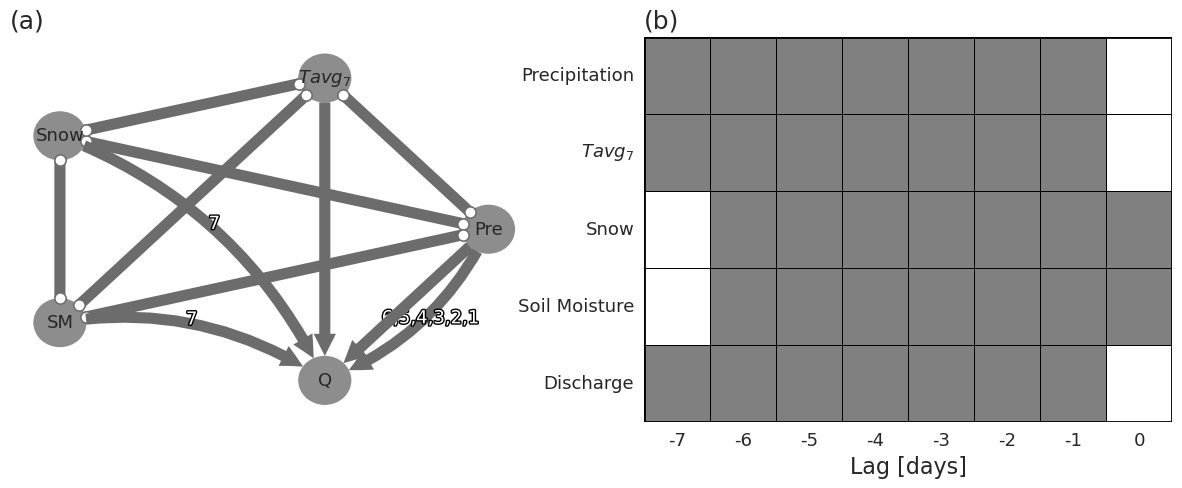

In [14]:
from causal_discovery_tools import get_link_assumptions, mask_builder

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
var_names_long = ["Precipitation", r"$Tavg_7$", "Snow", "Soil Moisture", "Discharge"]

# make the link assumptions plot and save it as a png - will then be loaded and added to the full plot
var_names = ["Pre", r"$Tavg_7$", "Snow", "SM", "Q"]
link_assumptions = get_link_assumptions()

link_assumptions_matrix = link_assumtion_dict_to_matrix(link_assumptions, 7, 5)
# to get correct edge orientation in link assumption plot
link_assumptions_matrix[4,0,0] = 0
link_assumptions_matrix[4,1,0] = 0
val_matrix = np.ones(link_assumptions_matrix.shape)*0.3
# fig1,ax1 = plt.subplots(figsize = (7.5,5))
tp.plot_graph(
    val_matrix=val_matrix,
    graph=link_assumptions_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False,
    cmap_edges = 'Greys',
    cmap_nodes = 'Greys',
    vmin_nodes = -0.5,
    node_label_size=fontsize_ticks,
    link_label_fontsize=fontsize_ticks,
    show_colorbar=False,
    fig_ax = (fig, ax[0])
    )

ax[0].set_title("(a)", fontsize = fontsize_title,loc='left')



mask = ~mask_builder(np.ones((8,5)),[7])
mask_pivot = mask.transpose()


# # add the first plots image as a subplot
# link_assumptions_plot = plt.imread('paper_plots/link_assumptions.png')
# ax[0].imshow(link_assumptions_plot, aspect = 'auto')
# ax[0].axis('off')  # Hide axes
# ax[0].set_title('(a)', fontsize = 16, loc = 'left')


sns.heatmap(mask_pivot.astype(int), cmap="gray", cbar=False, linewidths=0.5, linecolor='black', xticklabels=[-7,-6,-5,-4,-3,-2,-1,0], yticklabels=var_names_long,vmin=-1, vmax = 1, ax = ax[1])
ax[1].set_xlabel("Lag [days]", fontsize = fontsize_legend)
rect = plt.Rectangle((0, 0), mask_pivot.shape[1], mask_pivot.shape[0], fill=False, edgecolor='black', linewidth=2)
ax[1].add_patch(rect)
ax[1].set_title("(b)",fontsize = fontsize_title,loc='left')

plt.savefig('paper_plots/links_assumptions_mask.pdf', bbox_inches='tight', format = 'pdf')


## Input data - timeseries

ic| basin_id: 6136200


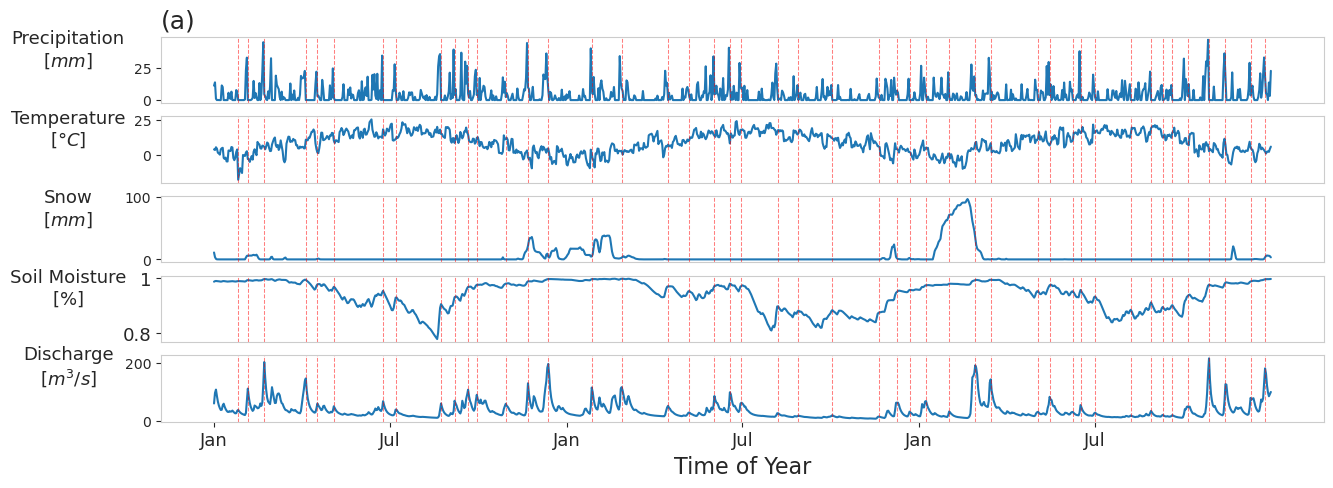

In [7]:
runtype = "production"
with initialize(config_path="conf/io", version_base=None):
    conf = compose(config_name=runtype)

# define basin ids
basin_ids = conf['ids']


basin_id = 6136200
ic(basin_id)
data_path = Path('/data/compoundx/causal_flood/stability_testing/data/resampled')
basin_timeseries = pd.read_csv(data_path / f'{basin_id}.csv')
# basin_timeseries.set_index('time', inplace=True)
basin_timeseries.index.names = ['index']


peak_indices = []
with open(
    data_path / f'{basin_id}_peak_indices_USWRC.txt', "r"
) as filehandle:
    peak_indices = [
        current_place.rstrip() for current_place in filehandle.readlines()
    ]
    # convert the read list to integers (instead of strings)
    peak_indices = list(map(int, peak_indices))

data = basin_timeseries.iloc[100*365:103*365]
# data = basin_timeseries.iloc[100*365:100*365 + 6]

fig, ax = plt.subplots(5,1, figsize=(15, 5), sharex=True)
# fig.tight_layout()
# plt.subplots_adjust(left=0.3)


for a in ax:
    a.tick_params(left=True, bottom=False)
    a.yaxis.set_label_coords(-0.08, 0)


sns.lineplot(data = data, x = 'index', y = 'Q', ax = ax[4], linewidth = 1.5)
ax[4].set_ylabel(r'Discharge' '\n' r'[$m^3/s$]', rotation = 0 ,fontsize = fontsize_ticks)
ax[4].grid(False)

sns.lineplot(data = data, x = 'index', y = 'pre', ax = ax[0])
ax[0].set_ylabel(r'Precipitation' '\n' r'[$mm$]', rotation = 0 ,fontsize = fontsize_ticks)
ax[0].grid(False)

sns.lineplot(data = data, x = 'index', y = 'snow', ax = ax[2])
ax[2].set_ylabel(r'Snow' '\n' r'[$mm$]', rotation = 0 ,fontsize = fontsize_ticks)
ax[2].grid(False)

sns.lineplot(data = data, x = 'index', y = 'SM', ax = ax[3])
ax[3].set_ylabel(r'Soil Moisture' '\n' r'[$\%$]', rotation = 0 ,fontsize = fontsize_ticks)
ax[3].grid(False)
ax[3].set_yticks([0.8,1], labels = [0.8,1], fontsize  = fontsize_ticks)

sns.lineplot(data = data, x = 'index', y = 'tavg', ax = ax[1])
ax[1].set_ylabel(r'Temperature' '\n' r'[$°C$]', rotation = 0 ,fontsize = fontsize_ticks)
ax[1].grid(False)


peaks = [p for p in peak_indices if p >=100*365 and p < 103*365]
# peaks = peak_indices

for a in ax:
    for peak in peaks:
        a.axvline(x=peak, color='red', linestyle='--', alpha = 0.5, linewidth = 0.75)


plt.xticks([100*365,100*365 + 182,101*365,101*365 + 182, 102*365, 102*365 + 182])
ax[4].tick_params(left=True, bottom=True)
ax[4].set_xticklabels(['Jan','Jul','Jan','Jul','Jan','Jul'], fontsize = fontsize_ticks)
ax[4].set_xlabel('Time of Year', fontsize = fontsize_legend)
ax[0].set_title(f'(a)',fontsize = fontsize_title,loc='left')
plt.savefig('paper_plots/example_timeseries.pdf', bbox_inches='tight', format = 'pdf')

## input data - map of basins

In [17]:
# read shijies results and grdc baisin data
results_shijie = pd.read_csv('/data/compoundx/causal_flood/shijie/EU_Catchments.csv', index_col=0).loc[basin_ids,['all_dominance']]
results_shijie = results_shijie.rename_axis('id')
grdc_info_file = '/data/compoundx/GRDC_runoff/GRDC_Stations.xlsx'
grdc_info = pd.read_excel(grdc_info_file)
grdc_info = grdc_info.rename(columns={'grdc_no':'id'})
grdc_info = grdc_info.set_index('id').loc[basin_ids,['lat','long']]
# merge the two dataframes and select only the baisin ids used in this study
basin_info = pd.merge(results_shijie, grdc_info, on= 'id', how='outer')
# basin_info = basin_info.loc[basin_ids]

# Ensure 'all_dominance' is treated as a categorical variable
basin_info['all_dominance'] = pd.Categorical(basin_info['all_dominance'], categories=basin_info.all_dominance.unique(), ordered=False)
# rename the categories to be better represented in the final plot
basin_info['all_dominance'] = basin_info['all_dominance'].cat.rename_categories({'mixed (r+a)': 'mixed rainfall', 'antecedent rainfall (a)': 'antecedent rainfall', 'recent rainfall (r)': 'recent rainfall', 'snowmelt (s)':'snowmelt'})


In [18]:
series_id = 6136200

grdc_info_file = '/data/compoundx/GRDC_runoff/GRDC_Stations.xlsx'
grdc_info = pd.read_excel(grdc_info_file)
grdc_info = grdc_info.rename(columns={'grdc_no':'id'})
grdc_info = grdc_info.set_index('id')
grdc_info.loc[series_id]

wmo_reg                      6
sub_reg                   6361
river            MOSELLE RIVER
station                 EPINAL
country                     FR
lat                  48.164617
long                  6.452056
area                    1220.0
altitude                 369.2
d_start                 1960.0
d_end                   2012.0
d_yrs                     53.0
d_miss                     0.0
m_start                    NaN
m_end                      NaN
m_yrs                      NaN
m_miss                     NaN
t_start                   1960
t_end                     2012
t_yrs                       53
lta_discharge           38.149
r_volume_yr           1.203067
r_height_yr          986.12038
Name: 6136200, dtype: object

/tmp/ipykernel_999646/4256608991.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_map = plt.subplot(1,2,1,projection=ccrs.PlateCarree())


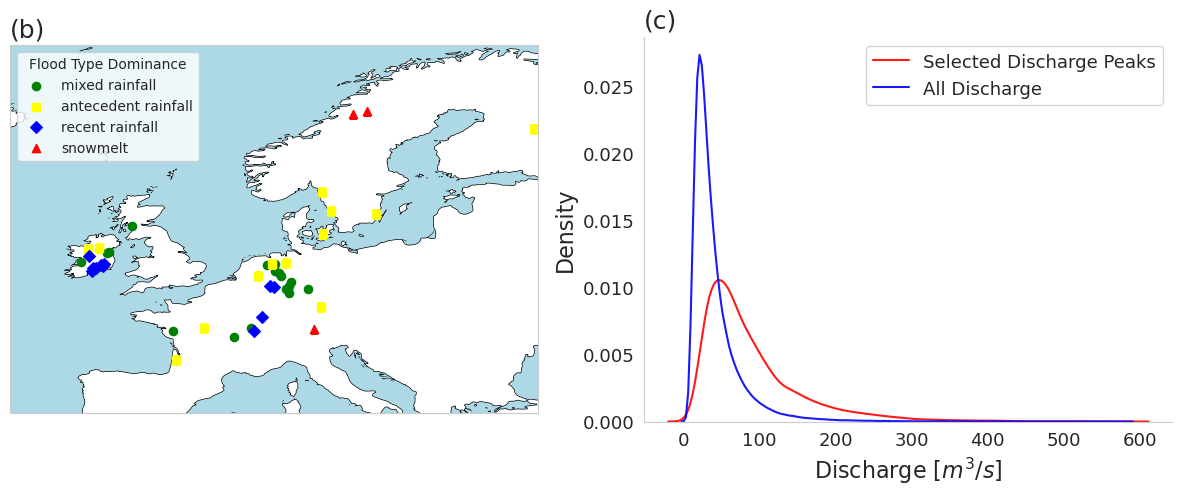

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Create the plot with Cartopy
ax_map = plt.subplot(1,2,1,projection=ccrs.PlateCarree())

# Set extent to focus on Europe
ax_map.set_extent([-15, 30, 40, 70])

# Add natural features to the map
ax_map.add_feature(cfeature.LAND, edgecolor='black', facecolor='white')  # Land color
ax_map.add_feature(cfeature.OCEAN, facecolor='lightblue')
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# define the colors on the map 
colors = {'mixed rainfall':'green', 'antecedent rainfall':'yellow', 'recent rainfall':'blue', 'snowmelt':'red'}
# for visibility without colors
markers = {'mixed rainfall':'o', 'antecedent rainfall':'s', 'recent rainfall':'D', 'snowmelt':'^'}

# Plot each category with its color
for dominance in basin_info['all_dominance'].cat.categories:
    subset = basin_info[basin_info['all_dominance'] == dominance]
    ax_map.scatter(subset['long'], subset['lat'],color=colors[dominance],  label=dominance,marker=markers[dominance], s=35, transform=ccrs.PlateCarree())


# Hide the border around the map
# for spine in ax.spines.values():
#     spine.set_visible(False)

# Add a legend
ax_map.legend(title='Flood Type Dominance')
ax_map.set_title(f'(b)',fontsize = fontsize_title,loc='left')


peaks = basin_timeseries.iloc[peak_indices]
bin_edges_all = np.arange(0,600, 10)
bin_edges_peak = np.arange(0,600,10)
sns.kdeplot(peaks['Q'], color='red',alpha = 0.9, label = 'Selected Discharge Peaks', ax=ax[1])
sns.kdeplot(basin_timeseries['Q'], color='blue', alpha = 0.9, label = 'All Discharge', ax = ax[1])
ax[1].set_xlabel(r'Discharge [$m^3/s$]', fontsize = fontsize_legend)
ax[1].set_ylabel('Density', fontsize = fontsize_legend)
ax[1].set_title(f'(c)',fontsize = fontsize_title,loc='left')
ax[1].legend(fontsize  = fontsize_ticks)
ax[1].grid(False)
sns.despine()

plt.savefig('paper_plots/map_histogram.pdf', bbox_inches='tight',format = 'pdf')


# Heatmap plots of which edges are detected for a given sample size

## load data

In [5]:
# read shijies results and grdc baisin data
results_shijie = pd.read_csv('/data/compoundx/causal_flood/shijie/EU_Catchments.csv', index_col=0).loc[basin_ids,['all_dominance']]
results_shijie = results_shijie.rename_axis('id')

# [
# 6335351, (mixed)
# 6731600, (snow)
# 6503281 (recent rainfall)
# ]


selected_basin_ids = [
                    6335351,
                    6731600,
                    6503281
                    ]



## GPDC Heatmaps

/tmp/ipykernel_737246/4067699487.py:151: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_for_plotting = df_for_plotting.pivot("sample_size", "name", "count").fillna(0)
/tmp/ipykernel_737246/4067699487.py:151: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_for_plotting = df_for_plotting.pivot("sample_size", "name", "count").fillna(0)
/tmp/ipykernel_737246/4067699487.py:151: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_for_plotting = df_for_plotting.pivot("sample_size", "name", "count").fillna(0)
/tmp/ipykernel_737246/4067699487.py:151: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_for_plotting = df_for_plotting.pivot("sample_size", "name", "count").fillna(0)


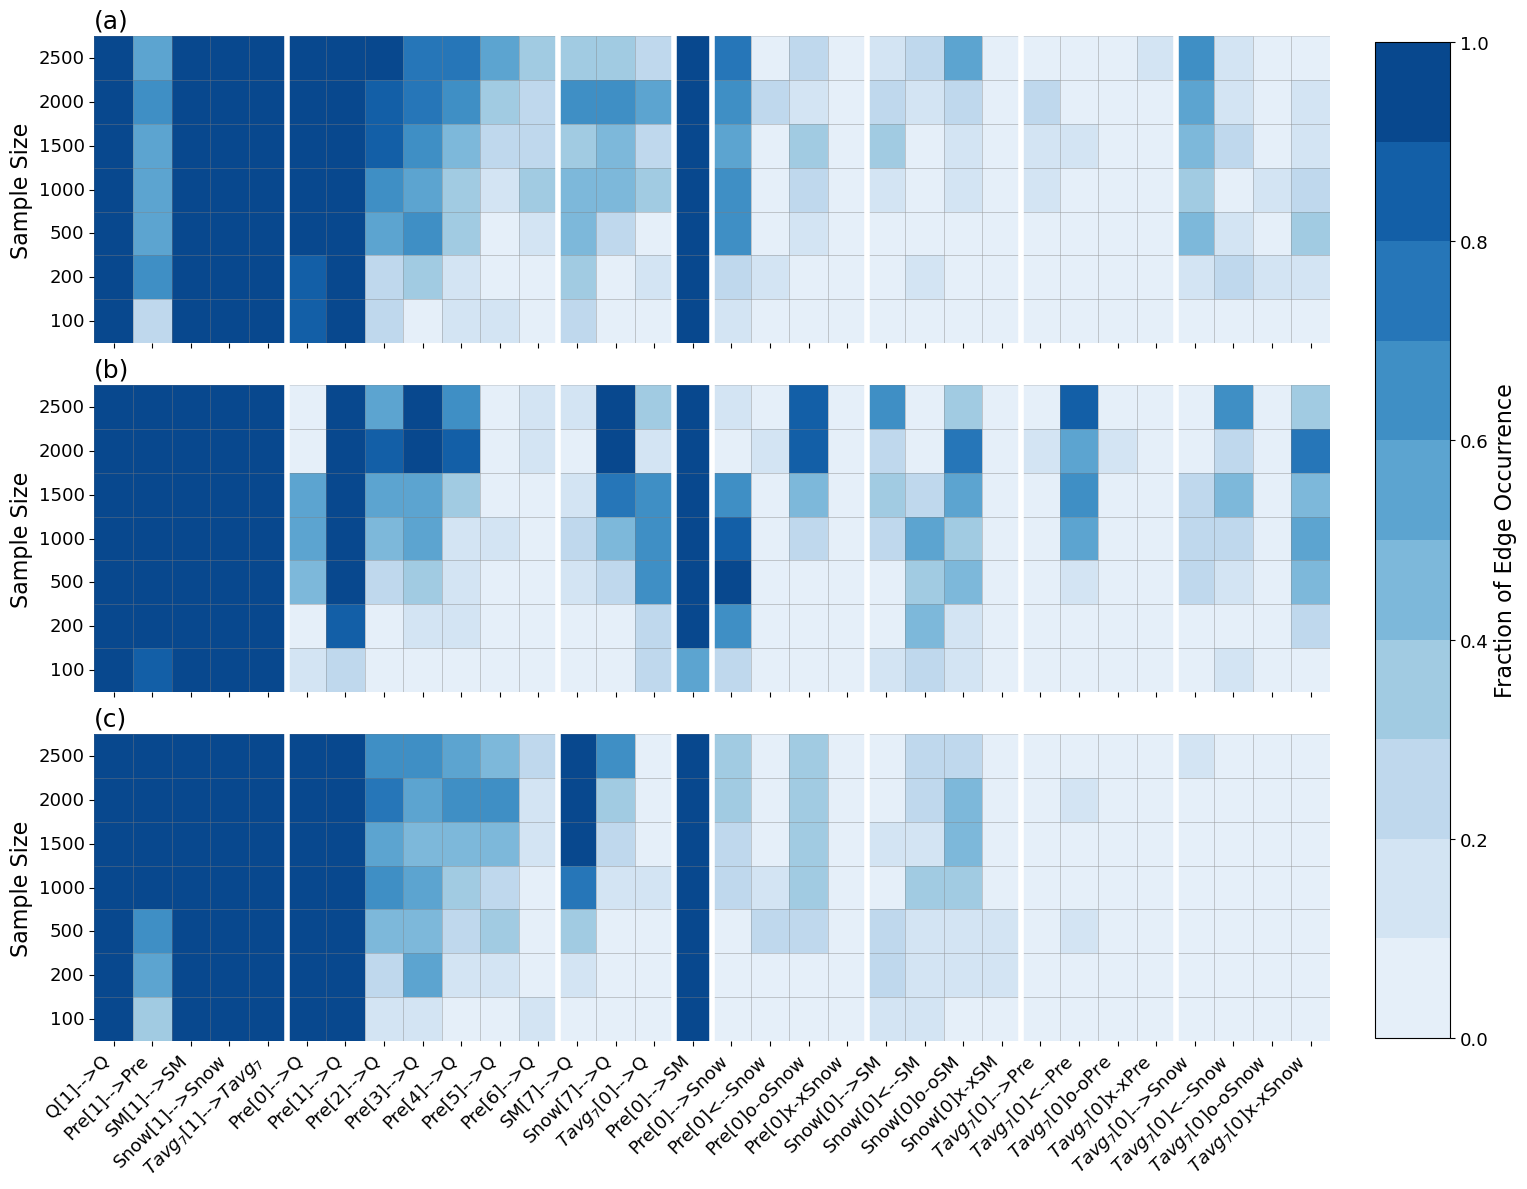

In [6]:
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
plt.rcParams['xtick.labelsize'] = fontsize_ticks
plt.rcParams['ytick.labelsize'] = fontsize_ticks
# all_possible_link_types = ['-->', '<--', 'o-o', 'x-x']
# var_names = ["Pre", r"$Tavg_7$", "Snow", "SM", "Q"]


colors = ListedColormap(sns.color_palette("Blues", 10))

# def fraction_of_link_occurrence(graphs:list, all_possible_link_types:list, var_names:list):
#     max_count = len(graphs)
#     # iterate through the different links. since all graphs must have the same maximum size, we iterate through one of them instead
#     for index, edge in np.ndenumerate(graphs[0]):
#         pass
    
def convert_list_of_arrays_into_array_of_lists(list_of_arrays:list):
    # to convert a list of graphs resulting from causal discovery to an array the size of the graph-array with each entry a list of the discovered link types for this variable
    array_of_lists = np.empty(list_of_arrays[0].shape, dtype=object)
    for index, _  in np.ndenumerate(list_of_arrays[0]):
        values = []
        for array in list_of_arrays:
            values.append(array[index])
        array_of_lists[index] = values

    return(array_of_lists)

def count_link_types_fraction(array_of_lists:np.ndarray, var_names:list, sample_size:int=0) -> pd.DataFrame:
    # calculates the fraction of times a particular link is present
    all_counted_link_types = pd.DataFrame(columns=['count', 'sample_size','node1', 'node2', 'lag', 'link', 'name'])
    for index, link_types in np.ndenumerate(array_of_lists):
        counted_link_types = Counter(link_types)
        for key in counted_link_types:
            # link_name = f'{var_names[index[0]]}:{key}:{var_names[index[1]]}@t{index[2]}'
            link_name = f'{var_names[index[0]]}[{index[2]}]{key}{var_names[index[1]]}'
            dataframe_entry  = pd.DataFrame({
                                'count':counted_link_types[key]/len(link_types),
                                'sample_size':sample_size,
                                'node1':var_names[index[0]],
                                'node2':var_names[index[1]],
                                'lag':index[2],
                                'link':key,
                                'name':link_name}
                                , index = [0])
            all_counted_link_types = pd.concat([all_counted_link_types, dataframe_entry], ignore_index=True)
            
    return all_counted_link_types

def get_dataframe_for_heatmap_plotting(models:list, sample_sizes:list, basin_id:int, cond_ind_test:str, var_names:list) -> pd.DataFrame:
    df_for_plotting = pd.DataFrame()
    for sample_size in sample_sizes:
        graphs = [model.discovery_result['graph'] for model in models if 
                            model.basin_id == basin_id and
                            model.sample_size == sample_size and
                            model.cond_ind_test == cond_ind_test]
        # if no graphs exist for the given sample size, skip
        if len(graphs) == 0:
            continue
        array_of_lists = convert_list_of_arrays_into_array_of_lists(graphs)
        count = count_link_types_fraction(array_of_lists,var_names, sample_size)
        df_for_plotting = pd.concat([df_for_plotting,count], ignore_index=True)
    # remove links that where not found from the dataframe
    df_for_plotting = df_for_plotting.loc[df_for_plotting['link'] != '']
    return df_for_plotting



var_names = ["Pre", r"$Tavg_7$", "Snow", "SM", "Q"]
sample_sizes = [100,200,500,1000,1500,2000, 2500,3000]
cond_ind_test = 'GPDC'
interesting_links_tuples = [
    ('Q', 'Q', 1),
    ('Pre', 'Q', 0),
    ('Pre', 'Q', 1),
    ('Pre', 'Q', 2),
    ('Pre', 'Q', 3),
    ('Pre', 'Q', 4),
    ('Pre', 'Q', 5),
    ('Pre', 'Q', 6),
    (r"$Tavg_7$", 'Q', 0),
    ('Snow', 'Q', 7),
    ('SM', 'Q', 7),
    ('Pre', 'SM', 0),
    ('Pre', 'Snow', 0),
    (r'$Tavg_7$','Pre', 0),
    ('Snow', 'SM', 0),
    (r'$Tavg_7$','Snow', 0),
    ('Pre', 'Pre', 1),
    ('Snow', 'Snow', 1),
    ('SM', 'SM', 1),
    (r'$Tavg_7$', r'$Tavg_7$', 1),
]

link_sorting_names = [
                        'Q[1]-->Q',
                        'Pre[1]-->Pre',
                        'SM[1]-->SM',
                        'Snow[1]-->Snow',
                        '$Tavg_7$[1]-->$Tavg_7$',

                        'Pre[0]-->Q',
                        'Pre[1]-->Q',
                        'Pre[2]-->Q',
                        'Pre[3]-->Q',
                        'Pre[4]-->Q',
                        'Pre[5]-->Q',
                        'Pre[6]-->Q',

                        'SM[7]-->Q',
                        'Snow[7]-->Q',
                        '$Tavg_7$[0]-->Q',

                        'Pre[0]-->SM',

                        'Pre[0]-->Snow',
                        'Pre[0]<--Snow', 
                        'Pre[0]o-oSnow',
                        'Pre[0]x-xSnow',

                        'Snow[0]-->SM',
                        'Snow[0]<--SM',
                        'Snow[0]o-oSM',
                        'Snow[0]x-xSM',

                        '$Tavg_7$[0]-->Pre',
                        '$Tavg_7$[0]<--Pre',
                        '$Tavg_7$[0]o-oPre',
                        '$Tavg_7$[0]x-xPre',

                        '$Tavg_7$[0]-->Snow',
                        '$Tavg_7$[0]<--Snow',
                        '$Tavg_7$[0]o-oSnow',
                        '$Tavg_7$[0]x-xSnow',
                        ]


major_divider_positions = [5, 12,15,16,20,24,28 ]

# plot 3 selected basins for the final paper in a single plot
fig,ax = plt.subplots(3,1,figsize=(15, 12), sharex = True)

subplot_names = ['(a)', '(b)','(c)']
for i,basin_id in enumerate(selected_basin_ids):

    interesting_links_df = pd.DataFrame(interesting_links_tuples, columns=['node1', 'node2', 'lag'])


    df_for_plotting = get_dataframe_for_heatmap_plotting(models = resampled_results, sample_sizes=sample_sizes, basin_id = basin_id, cond_ind_test = cond_ind_test, var_names = var_names)
    df_for_plotting = pd.merge(df_for_plotting, interesting_links_df, on=['node1', 'node2', 'lag'])
    df_for_plotting = df_for_plotting.pivot("sample_size", "name", "count").fillna(0)
    df_for_plotting = df_for_plotting.sort_values(by = 'sample_size', ascending = False)
    #only plot up to sample size 2500 for consistency between the 3 basins
    df_for_plotting = df_for_plotting[df_for_plotting.index <=2500]
    # ic(df_for_plotting.columns)
    for name in link_sorting_names:
        if name not in df_for_plotting.columns:
            df_for_plotting[name] = 0

    for name in df_for_plotting.columns:
        if name not in link_sorting_names:
            ic(f'{name} present but not used in heatmap plot')



    df_for_plotting = df_for_plotting[link_sorting_names]
    sns.heatmap(df_for_plotting, annot=False, cmap=colors, ax=ax[i], cbar = False)

    for pos in major_divider_positions:
        ax[i].axvline(x=pos, color='white', linewidth=4)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize = fontsize_ticks)
    ax[i].set_xlabel("", fontsize = 14)
    ax[i].set_ylabel("Sample Size", fontsize = fontsize_legend)
    ax[i].set_title(subplot_names[i],fontsize = fontsize_title,loc='left')
    # Draw light shading around each cell
    n_rows, n_cols = df_for_plotting.shape
    for a in range(n_rows):
        for b in range(n_cols):
            rect = Rectangle((b, a), 1, 1, linewidth=0.5, edgecolor='gray', facecolor='none', linestyle='-', alpha=0.3)
            ax[i].add_patch(rect)

    # Create a colorbar outside the whole figure
cbar_ax = fig.add_axes([0.92, 0.13, 0.05, 0.83])  # [left, bottom, width, height]
fig.colorbar(ax[2].collections[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to leave space for the colorbar
cbar_ax.set_ylabel('Fraction of Edge Occurrence', fontsize = fontsize_legend)
cbar_ax.tick_params(labelsize = fontsize_ticks)
plt.savefig('paper_plots/basin_heatmaps.pdf', bbox_inches='tight', format = 'pdf')




## ParCorr Heatmaps

/tmp/ipykernel_737246/934669776.py:151: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_for_plotting = df_for_plotting.pivot("sample_size", "name", "count").fillna(0)
/tmp/ipykernel_737246/934669776.py:151: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_for_plotting = df_for_plotting.pivot("sample_size", "name", "count").fillna(0)
/tmp/ipykernel_737246/934669776.py:151: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_for_plotting = df_for_plotting.pivot("sample_size", "name", "count").fillna(0)
/tmp/ipykernel_737246/934669776.py:151: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_for_plotting = df_for_plotting.pivot("sample_size", "name", "count").fillna(0)
/tmp

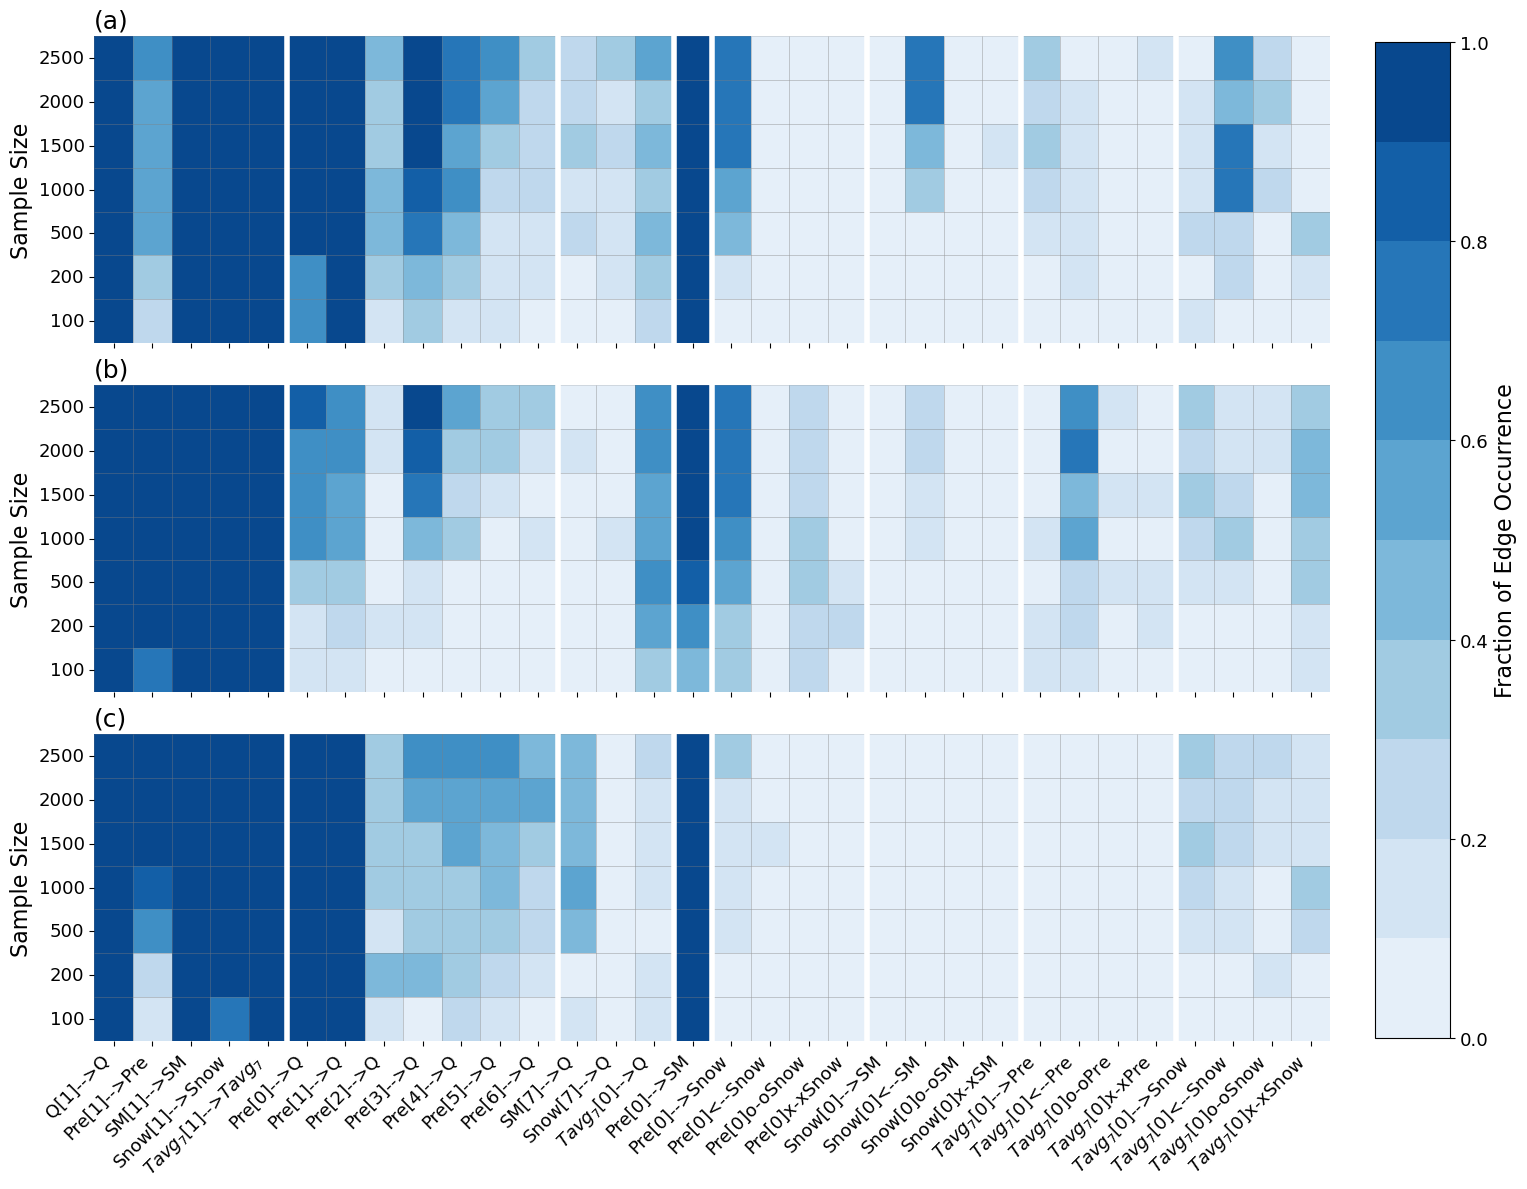

In [8]:
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
plt.rcParams['xtick.labelsize'] = fontsize_ticks
plt.rcParams['ytick.labelsize'] = fontsize_ticks
# all_possible_link_types = ['-->', '<--', 'o-o', 'x-x']
# var_names = ["Pre", r"$Tavg_7$", "Snow", "SM", "Q"]


colors = ListedColormap(sns.color_palette("Blues", 10))

# def fraction_of_link_occurrence(graphs:list, all_possible_link_types:list, var_names:list):
#     max_count = len(graphs)
#     # iterate through the different links. since all graphs must have the same maximum size, we iterate through one of them instead
#     for index, edge in np.ndenumerate(graphs[0]):
#         pass
    
def convert_list_of_arrays_into_array_of_lists(list_of_arrays:list):
    # to convert a list of graphs resulting from causal discovery to an array the size of the graph-array with each entry a list of the discovered link types for this variable
    array_of_lists = np.empty(list_of_arrays[0].shape, dtype=object)
    for index, _  in np.ndenumerate(list_of_arrays[0]):
        values = []
        for array in list_of_arrays:
            values.append(array[index])
        array_of_lists[index] = values

    return(array_of_lists)

def count_link_types_fraction(array_of_lists:np.ndarray, var_names:list, sample_size:int=0) -> pd.DataFrame:
    # calculates the fraction of times a particular link is present
    all_counted_link_types = pd.DataFrame(columns=['count', 'sample_size','node1', 'node2', 'lag', 'link', 'name'])
    for index, link_types in np.ndenumerate(array_of_lists):
        counted_link_types = Counter(link_types)
        for key in counted_link_types:
            # link_name = f'{var_names[index[0]]}:{key}:{var_names[index[1]]}@t{index[2]}'
            link_name = f'{var_names[index[0]]}[{index[2]}]{key}{var_names[index[1]]}'
            dataframe_entry  = pd.DataFrame({
                                'count':counted_link_types[key]/len(link_types),
                                'sample_size':sample_size,
                                'node1':var_names[index[0]],
                                'node2':var_names[index[1]],
                                'lag':index[2],
                                'link':key,
                                'name':link_name}
                                , index = [0])
            all_counted_link_types = pd.concat([all_counted_link_types, dataframe_entry], ignore_index=True)
            
    return all_counted_link_types

def get_dataframe_for_heatmap_plotting(models:list, sample_sizes:list, basin_id:int, cond_ind_test:str, var_names:list) -> pd.DataFrame:
    df_for_plotting = pd.DataFrame()
    for sample_size in sample_sizes:
        graphs = [model.discovery_result['graph'] for model in models if 
                            model.basin_id == basin_id and
                            model.sample_size == sample_size and
                            model.cond_ind_test == cond_ind_test]
        # if no graphs exist for the given sample size, skip
        if len(graphs) == 0:
            continue
        array_of_lists = convert_list_of_arrays_into_array_of_lists(graphs)
        count = count_link_types_fraction(array_of_lists,var_names, sample_size)
        df_for_plotting = pd.concat([df_for_plotting,count], ignore_index=True)
    # remove links that where not found from the dataframe
    df_for_plotting = df_for_plotting.loc[df_for_plotting['link'] != '']
    return df_for_plotting



var_names = ["Pre", r"$Tavg_7$", "Snow", "SM", "Q"]
sample_sizes = [100,200,500,1000,1500,2000, 2500,3000]
cond_ind_test = 'ParCorr'
interesting_links_tuples = [
    ('Q', 'Q', 1),
    ('Pre', 'Q', 0),
    ('Pre', 'Q', 1),
    ('Pre', 'Q', 2),
    ('Pre', 'Q', 3),
    ('Pre', 'Q', 4),
    ('Pre', 'Q', 5),
    ('Pre', 'Q', 6),
    (r"$Tavg_7$", 'Q', 0),
    ('Snow', 'Q', 7),
    ('SM', 'Q', 7),
    ('Pre', 'SM', 0),
    ('Pre', 'Snow', 0),
    (r'$Tavg_7$','Pre', 0),
    ('Snow', 'SM', 0),
    (r'$Tavg_7$','Snow', 0),
    ('Pre', 'Pre', 1),
    ('Snow', 'Snow', 1),
    ('SM', 'SM', 1),
    (r'$Tavg_7$', r'$Tavg_7$', 1),
]

link_sorting_names = [
                        'Q[1]-->Q',
                        'Pre[1]-->Pre',
                        'SM[1]-->SM',
                        'Snow[1]-->Snow',
                        '$Tavg_7$[1]-->$Tavg_7$',

                        'Pre[0]-->Q',
                        'Pre[1]-->Q',
                        'Pre[2]-->Q',
                        'Pre[3]-->Q',
                        'Pre[4]-->Q',
                        'Pre[5]-->Q',
                        'Pre[6]-->Q',

                        'SM[7]-->Q',
                        'Snow[7]-->Q',
                        '$Tavg_7$[0]-->Q',

                        'Pre[0]-->SM',

                        'Pre[0]-->Snow',
                        'Pre[0]<--Snow', 
                        'Pre[0]o-oSnow',
                        'Pre[0]x-xSnow',

                        'Snow[0]-->SM',
                        'Snow[0]<--SM',
                        'Snow[0]o-oSM',
                        'Snow[0]x-xSM',

                        '$Tavg_7$[0]-->Pre',
                        '$Tavg_7$[0]<--Pre',
                        '$Tavg_7$[0]o-oPre',
                        '$Tavg_7$[0]x-xPre',

                        '$Tavg_7$[0]-->Snow',
                        '$Tavg_7$[0]<--Snow',
                        '$Tavg_7$[0]o-oSnow',
                        '$Tavg_7$[0]x-xSnow',
                        ]


major_divider_positions = [5, 12,15,16,20,24,28 ]

# plot 3 selected basins for the final paper in a single plot
fig,ax = plt.subplots(3,1,figsize=(15, 12), sharex = True)

subplot_names = ['(a)', '(b)','(c)']
for i,basin_id in enumerate(selected_basin_ids):

    interesting_links_df = pd.DataFrame(interesting_links_tuples, columns=['node1', 'node2', 'lag'])


    df_for_plotting = get_dataframe_for_heatmap_plotting(models = resampled_results, sample_sizes=sample_sizes, basin_id = basin_id, cond_ind_test = cond_ind_test, var_names = var_names)
    df_for_plotting = pd.merge(df_for_plotting, interesting_links_df, on=['node1', 'node2', 'lag'])
    df_for_plotting = df_for_plotting.pivot("sample_size", "name", "count").fillna(0)
    df_for_plotting = df_for_plotting.sort_values(by = 'sample_size', ascending = False)
    #only plot up to sample size 2500 for consistency between the 3 basins
    df_for_plotting = df_for_plotting[df_for_plotting.index <=2500]
    # ic(df_for_plotting.columns)
    for name in link_sorting_names:
        if name not in df_for_plotting.columns:
            df_for_plotting[name] = 0

    for name in df_for_plotting.columns:
        if name not in link_sorting_names:
            ic(f'{name} present but not used in heatmap plot')



    df_for_plotting = df_for_plotting[link_sorting_names]
    sns.heatmap(df_for_plotting, annot=False, cmap=colors, ax=ax[i], cbar = False)

    for pos in major_divider_positions:
        ax[i].axvline(x=pos, color='white', linewidth=4)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize = fontsize_ticks)
    ax[i].set_xlabel("", fontsize = 14)
    ax[i].set_ylabel("Sample Size", fontsize = fontsize_legend)
    ax[i].set_title(subplot_names[i],fontsize = fontsize_title,loc='left')
    # Draw light shading around each cell
    n_rows, n_cols = df_for_plotting.shape
    for a in range(n_rows):
        for b in range(n_cols):
            rect = Rectangle((b, a), 1, 1, linewidth=0.5, edgecolor='gray', facecolor='none', linestyle='-', alpha=0.3)
            ax[i].add_patch(rect)

    # Create a colorbar outside the whole figure
cbar_ax = fig.add_axes([0.92, 0.13, 0.05, 0.83])  # [left, bottom, width, height]
fig.colorbar(ax[2].collections[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to leave space for the colorbar
cbar_ax.set_ylabel('Fraction of Edge Occurrence', fontsize = fontsize_legend)
cbar_ax.tick_params(labelsize = fontsize_ticks)
plt.savefig('paper_plots/basin_heatmaps_parcorr.pdf', bbox_inches='tight', format = 'pdf')


